In [284]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

import holidays

1 - Eliminar los datos nulos antes de dividir el dataset (train_test_split). Solo y_train? o todo el dataset. solo en en mi variable target 

Post train_test_split:

analisis descriptivo - evidenciar valores atipicos boxplot --- scatterplot --- realizar scatterplot bi-variado. ej: distancia vs precio (detectar outliers)

2 - Graficos post división

---- Supuesto de normalidad QQplot para poder realizar regresión en variable target? p-value < 0.05. ?  

heatmap para ver cuales variables prectoras esta correlacionado ( reducción de dim ) -> lo hacemos con X_train

3 - Outliers -> trabajar solo X_train. Diferenciar valores raros (imputo mediana) o errores(elimino). 3 desvios estandar-prob z-score(por fuera considerar outlier)

4 - Faltantes -> muy pocos (elimino) -> nuestro caso - Justificar : muy poco < 3-5% (calcular porcentaje representativo )

5- feriados eeuu



In [286]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [287]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [288]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


### 1 - Eliminación de datos faltantes en mi variable Target


In [290]:
# Eliminar datos faltantes en mi variable target si es que las hay para evitar desvalance de los datos post división

print(df['fare_amount'].isna().sum())


0


In [291]:
# chequeamos si existen valores menores o iguales a cero ya que estos serían errores

print((df['fare_amount'] <= 0).sum())

22


In [292]:
# Observamos los errores

errores = []

for i in df['fare_amount']:
    if i <= 0:
        errores.append(i)

print(errores) 

[0.0, 0.0, -5.0, -3.3, -3.5, 0.0, -49.57, -23.7, -52.0, -7.3, -52.0, -6.9, -5.7, -3.0, -10.9, 0.0, -3.5, -50.5, -3.5, -3.0, -5.5, 0.0]


In [293]:
porcentaje_error = (df['fare_amount'] <= 0).sum() / len(df) * 100

print(f"Porcentaje de error en variable target: {porcentaje_error}")


Porcentaje de error en variable target: 0.011000000000000001


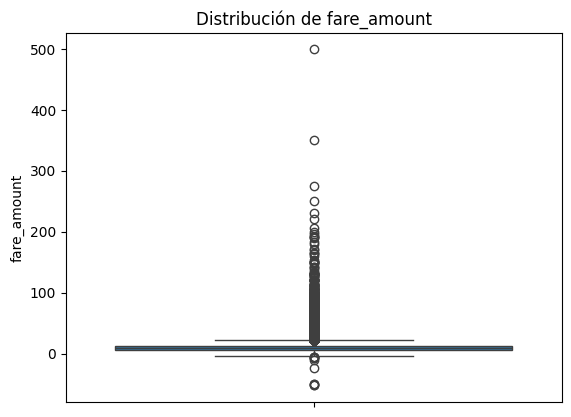

In [294]:
# Devido a que los errores representa un porcentaje muy bajo del dataset, decidimos imputar esos valores.
# Para ello vamos a observar como se distribuye el 'fare_amount' y tomar una desición sobre con qué métrica imputar

sns.boxplot(df['fare_amount'])
plt.title('Distribución de fare_amount')
plt.show()

In [295]:
# Ya que el porcentaje es muy bajo decidimos imputar esos valores faltantes usando la mediana

# Calculamos la mediana excluyendo los valores erroneos

# preguntar
median_fare = df[df['fare_amount'] > 0]['fare_amount'].median()

# Reemplazamos los valores erroneos por la mediana
df['fare_amount'] = df['fare_amount'].apply(lambda x: median_fare if x <= 0 else x) 


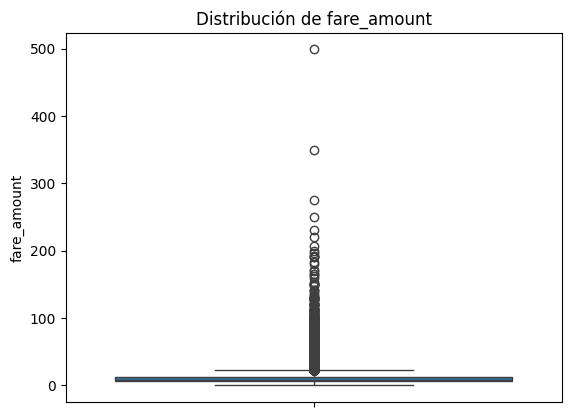

In [296]:
# Volvemos a visualizar 

sns.boxplot(df['fare_amount'])
plt.title('Distribución de fare_amount')
plt.show()

### 2 - Creación de features de interes

#### Calculo de la distancia de Haversine

In [297]:
import numpy as np

# Radio de la Tierra en kilómetros
R = 6371  

# convertimos a radianes
df['pickup_latitude'] = np.radians(df['pickup_latitude'])
df['pickup_longitude'] = np.radians(df['pickup_longitude'])
df['dropoff_latitude'] = np.radians(df['dropoff_latitude'])
df['dropoff_longitude'] = np.radians(df['dropoff_longitude'])

# Realizamos la diferencia entre los radianes
delta_lat = df['dropoff_latitude'] - df['pickup_latitude']
delta_lon = df['dropoff_longitude'] - df['pickup_longitude']

# fórmula de Haversine
df['d_haversine'] = 2 * R * np.arcsin(np.sqrt(
    np.sin(delta_lat  / 2) ** 2 +
    np.cos(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) *
    np.sin(delta_lon / 2) ** 2
))

# Unidad en kilometros

df['d_haversine'].head(3)

0    1.683323
1    2.457590
2    5.036377
Name: d_haversine, dtype: float64

#### Tratamiento fecha. Obtención de nuevas características

In [298]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['month'] = df['pickup_datetime'].dt.month
df['days_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour 

Trabajo con una copia para realizar un estudio preliminar de las nuevas features a realizar

In [299]:
df_copy = df.copy()

In [300]:
q99 = df_copy['fare_amount'].quantile(0.99)
df_copy = df_copy[df_copy['fare_amount'] <= q99]

<Axes: xlabel='month', ylabel='fare_amount'>

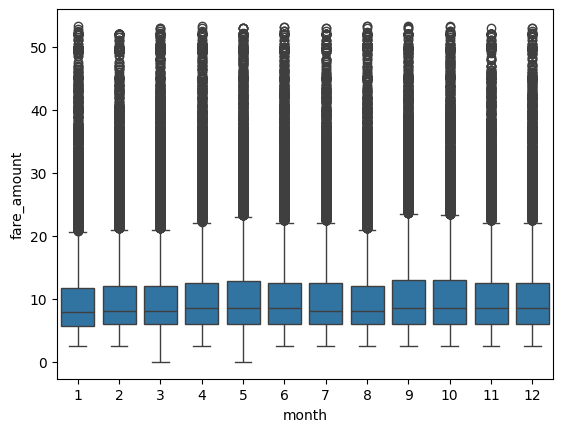

In [301]:
sns.boxplot( x='month', y='fare_amount', data=df_copy)

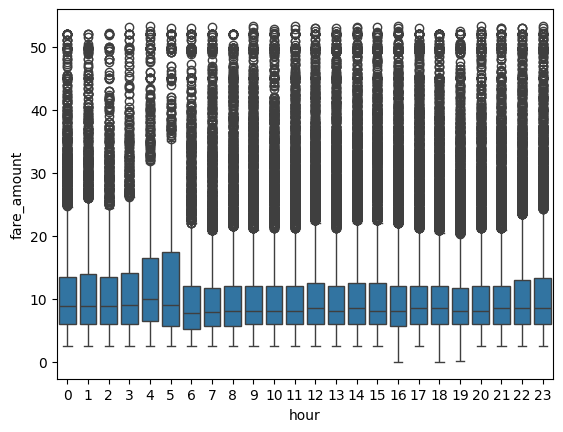

In [302]:
sns.boxplot( x='hour', y='fare_amount', data=df_copy)
plt.show()

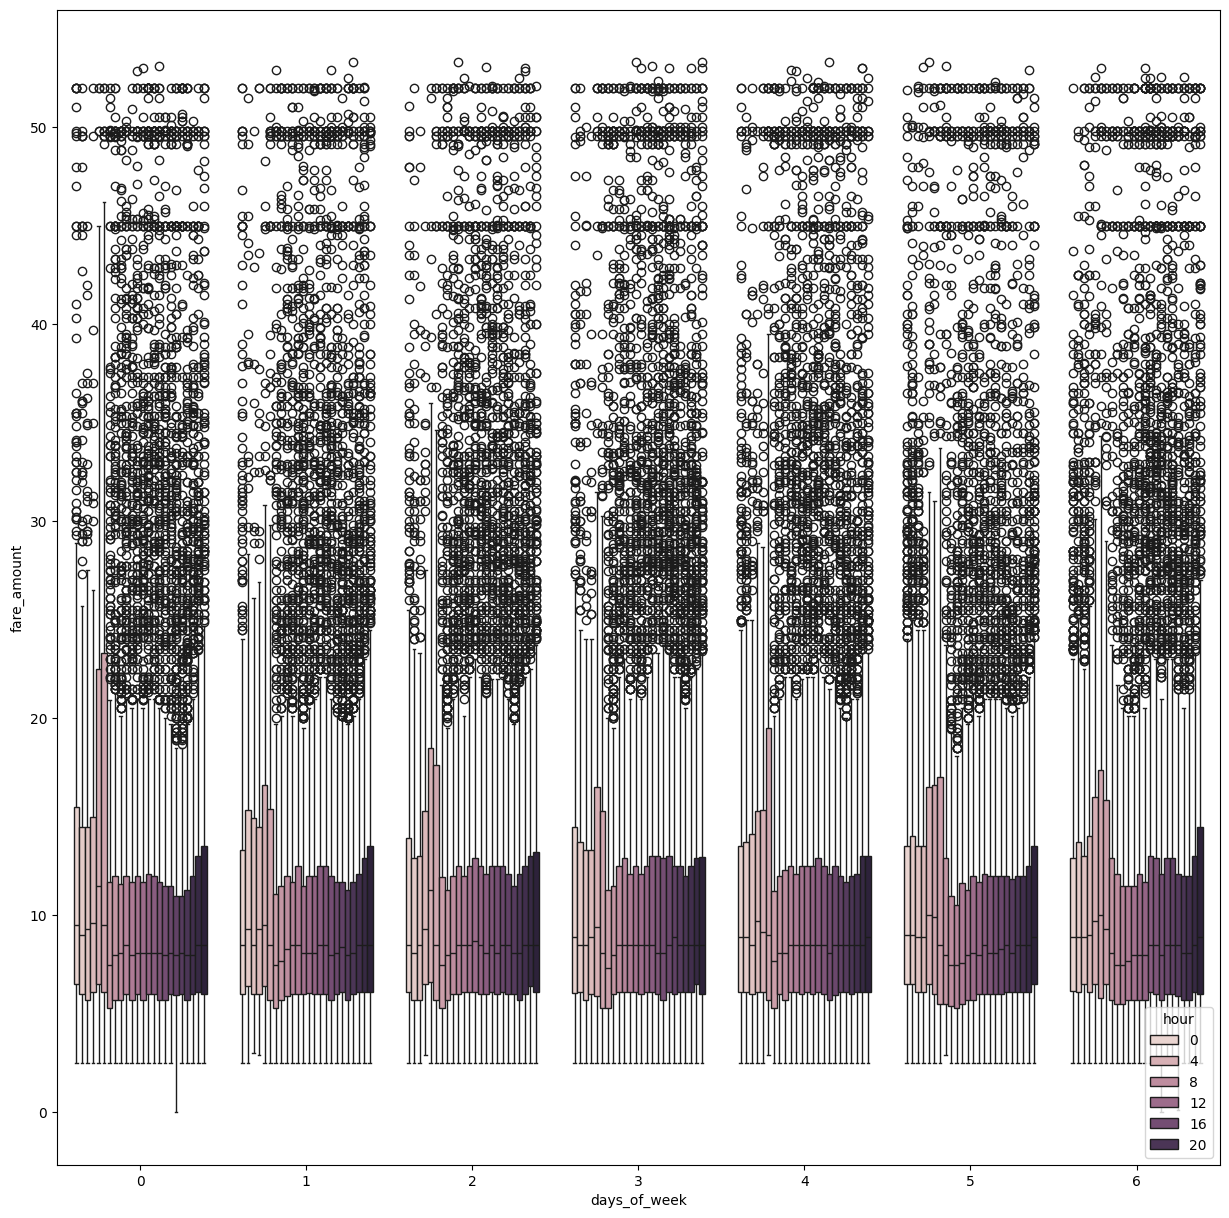

In [303]:
plt.figure(figsize=(15,15))
sns.boxplot( x='days_of_week', y='fare_amount', data=df_copy, hue='hour')
plt.show()

Hipotesis preliminares:

Podemos observar una clara diferencia en las distribuciones de tafirfas en las franjas de colores mas claras, muestran valores atípicos mas altos y unas dispersión mayor.

Por lo tanto crearemos una nueva feature segmentando la hora en 4 franjas horarias.

In [304]:
# creamos una nueva categoria con franjas de 6 horas

def categorizacion_hora(hour):
    if 0 <= hour < 6:
        return "madrugada"
    elif 6 <= hour < 12:
        return "mañana"
    elif 12 <= hour < 18:
        return "tarde"
    else:
        return "noche"

df['part_of_day'] = df['hour'].apply(categorizacion_hora)

In [305]:
df['part_of_day'].head()

0     noche
1     noche
2     noche
3    mañana
4     tarde
Name: part_of_day, dtype: object

Los feriados podrían generarnos patrones de movilidad únicos, por lo tanto, vamos a diferenciarlos

<Axes: ylabel='pickup_datetime'>

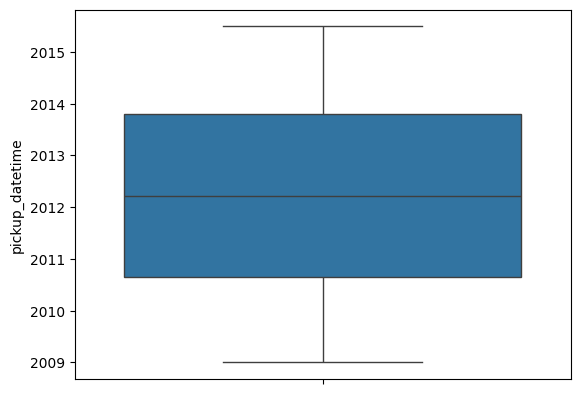

In [306]:
# Vsiualizamos la distribución de los años

sns.boxplot(df['pickup_datetime'])

In [307]:
# vemos que la mediana se encuentra aproximadamente en 2012.Elegimimos el año 2012 para los feriados

feriados = holidays.US(years=[2012])

df['is_holiday'] = df['pickup_datetime'].dt.date.apply(lambda x: 1 if x in feriados else 0)

# visualizamos
df_holidays = df[df['is_holiday'] == 1]
print(df_holidays[['pickup_datetime', 'is_holiday']].head(10))

              pickup_datetime  is_holiday
22  2009-11-26 02:58:00+00:00           1
68  2015-02-16 11:19:55+00:00           1
170 2013-10-14 20:28:00+00:00           1
291 2010-01-01 20:33:00+00:00           1
375 2015-05-25 16:23:08+00:00           1
427 2010-07-04 17:10:17+00:00           1
431 2010-07-04 20:20:27+00:00           1
455 2012-07-04 17:39:45+00:00           1
497 2010-01-18 02:18:16+00:00           1
510 2011-01-17 11:45:00+00:00           1


Trabajamos sobre la feature 'passenger_count', clasificamos segun la cantidad de pasajeros

In [308]:
df['passenger_count'].unique()

array([  1,   3,   5,   2,   4,   6,   0, 208])

In [309]:
median_passenger = df['passenger_count'].median()

df['passenger_count'] = df['passenger_count'].apply(lambda x: median_passenger if x > 6 else int(x))

df['passenger_count'].unique()

array([1., 3., 5., 2., 4., 6., 0.])

In [310]:
def categorizacion_uber(pasajeros):
    if pasajeros == 0:
        return "envio"
    elif 1 <= pasajeros <= 4:
        return "uber"
    else:
        return "uberXL"

df['uber_trip'] = df['passenger_count'].apply(categorizacion_uber)


### 3 - División del conjunto de datos

In [311]:
# Dividimos 

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

In [317]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 153248 to 121958
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                160000 non-null  int64              
 1   date               160000 non-null  object             
 2   pickup_datetime    160000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   160000 non-null  float64            
 4   pickup_latitude    160000 non-null  float64            
 5   dropoff_longitude  159999 non-null  float64            
 6   dropoff_latitude   159999 non-null  float64            
 7   passenger_count    160000 non-null  float64            
 8   d_haversine        159999 non-null  float64            
 9   month              160000 non-null  int32              
 10  days_of_week       160000 non-null  int32              
 11  hour               160000 non-null  int32              
 12  part_of_day        160000 non-

### 4 - EDA (Análisis exploratorio de los datos)

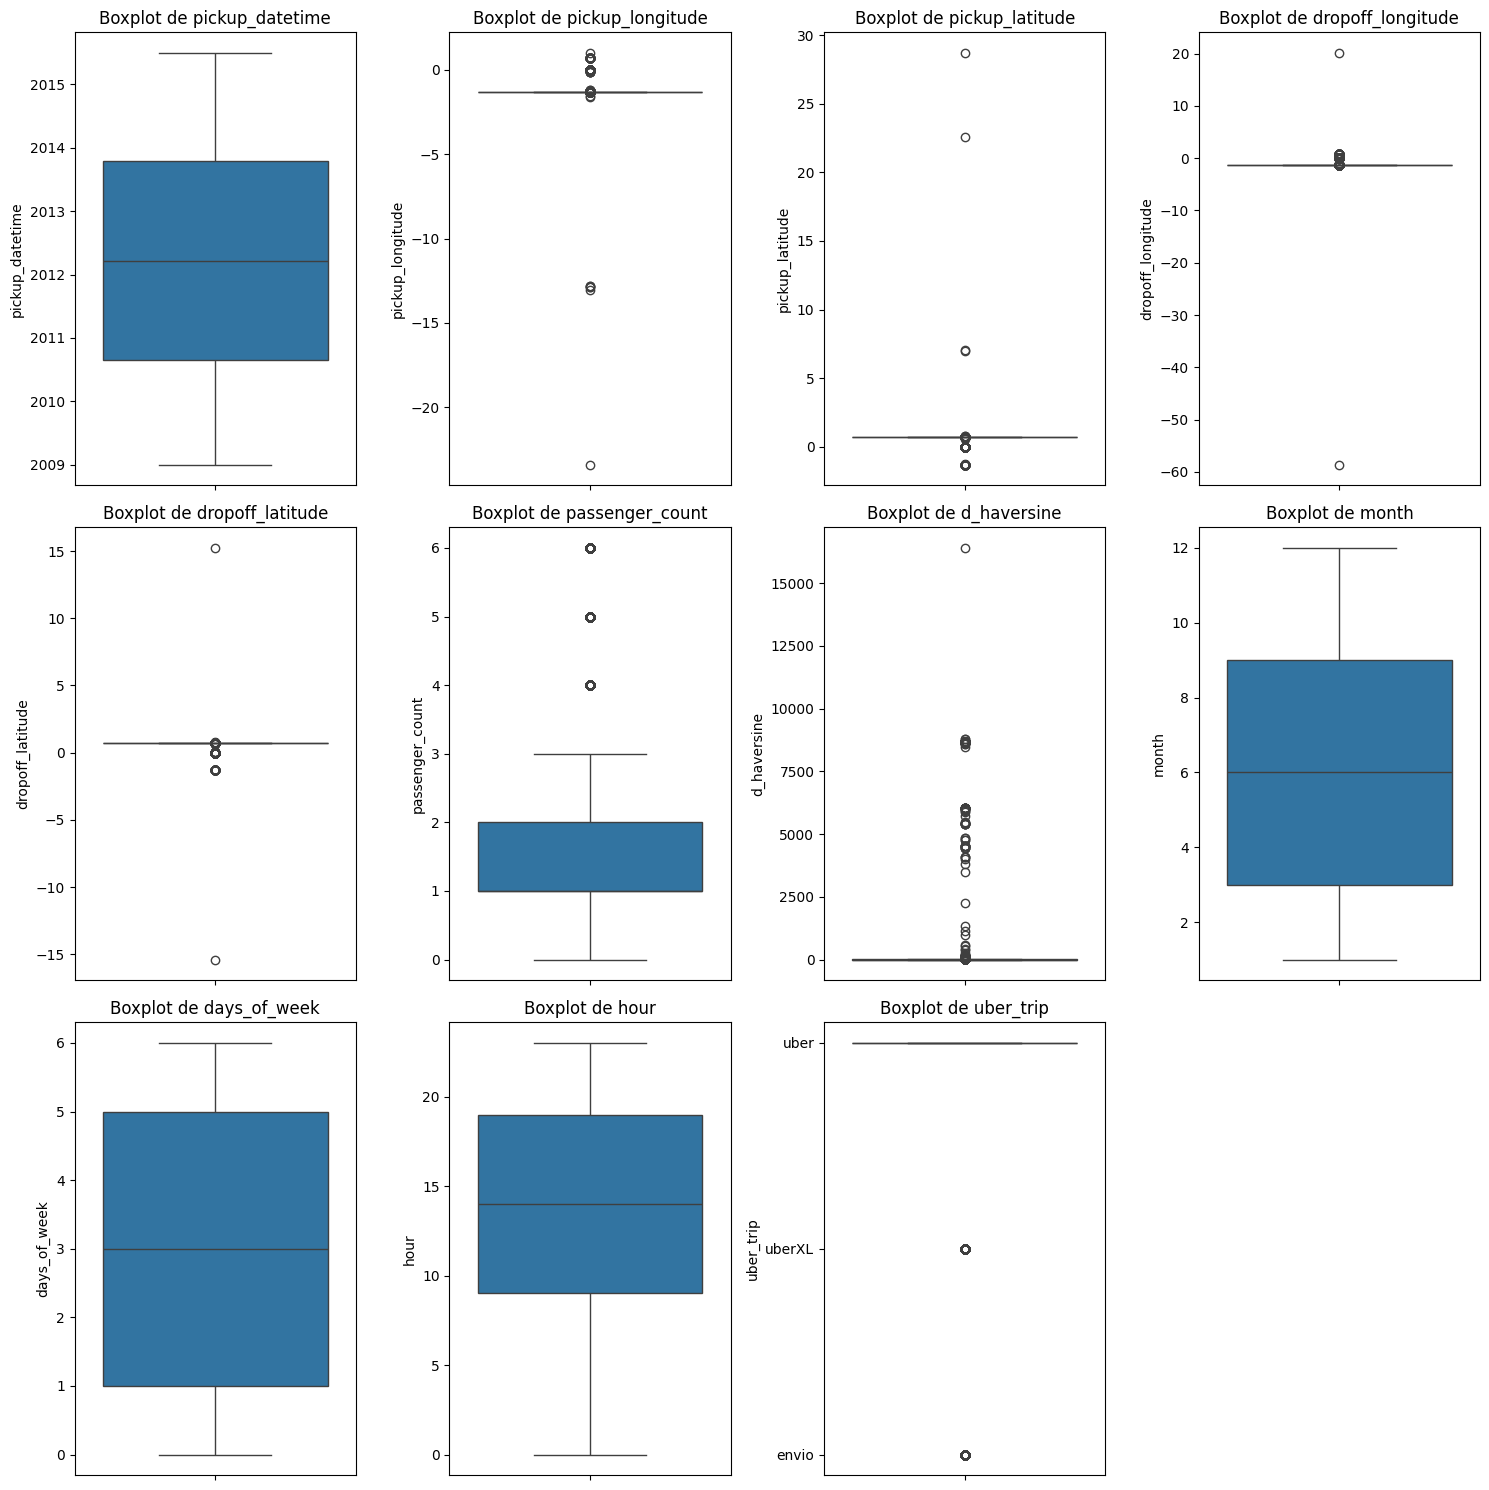

In [312]:
# Boxplot de las features
   
plt.figure(figsize=(15,15))
columnas = X_train.drop(columns=['key','date','part_of_day','is_holiday']).columns
for column in range(len(columnas)):
    plt.subplot(3, 4, column + 1)
    sns.boxplot(y=X_train[columnas[column]])
    plt.title(f'Boxplot de {columnas[column]}')
plt.tight_layout()
plt.show()

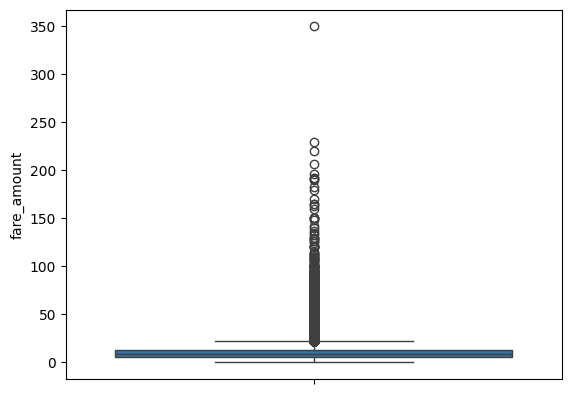

In [313]:
# Analisis de nuestra variable target 

sns.boxplot(y_train)
plt.show()

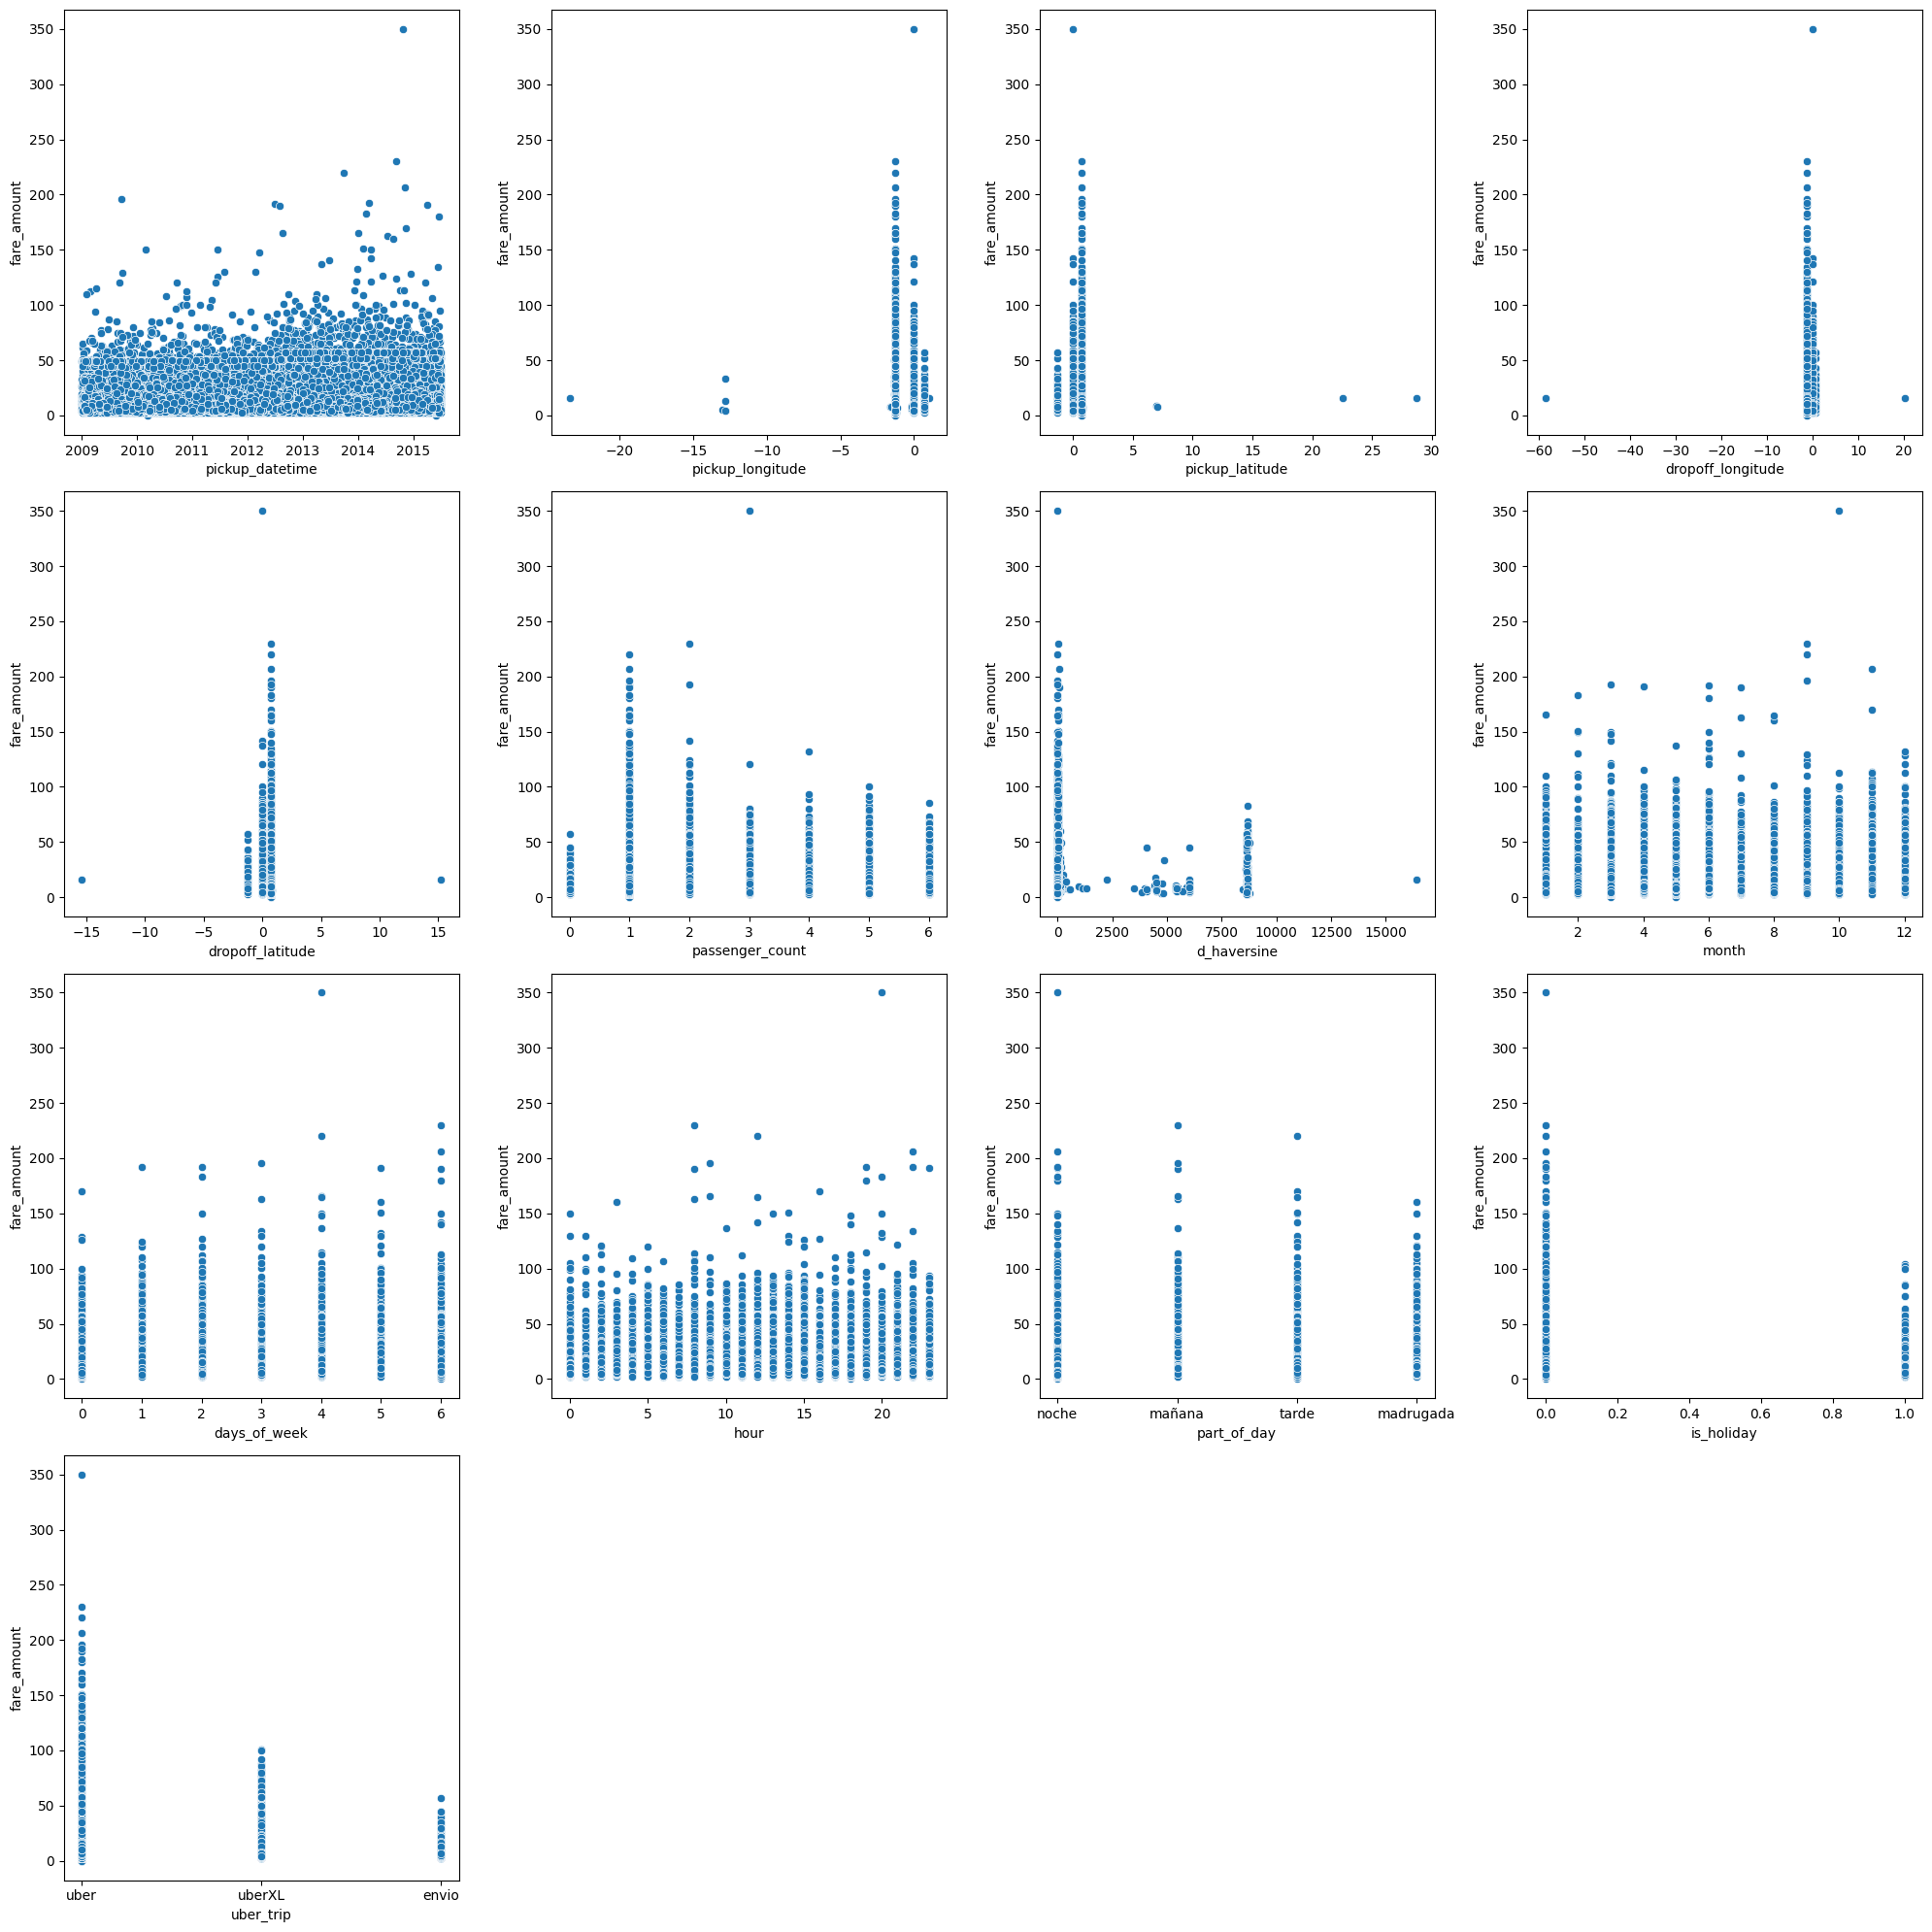

In [314]:
# Análisis de outliers respecto a fare_amount

columnas = X_train.drop(columns=['key','date']).columns

plt.figure(figsize=(20,20))

for column in range(len(columnas)):
    plt.subplot(4, 4, 1 + column)
    sns.scatterplot( x = X_train[columnas[column]], y = y_train)
plt.tight_layout()
plt.show()    

In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                200000 non-null  int64              
 1   date               200000 non-null  object             
 2   fare_amount        200000 non-null  float64            
 3   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 4   pickup_longitude   200000 non-null  float64            
 5   pickup_latitude    200000 non-null  float64            
 6   dropoff_longitude  199999 non-null  float64            
 7   dropoff_latitude   199999 non-null  float64            
 8   passenger_count    200000 non-null  float64            
 9   d_haversine        199999 non-null  float64            
 10  month              200000 non-null  int32              
 11  days_of_week       200000 non-null  int32              
 12  hour               200000 non-

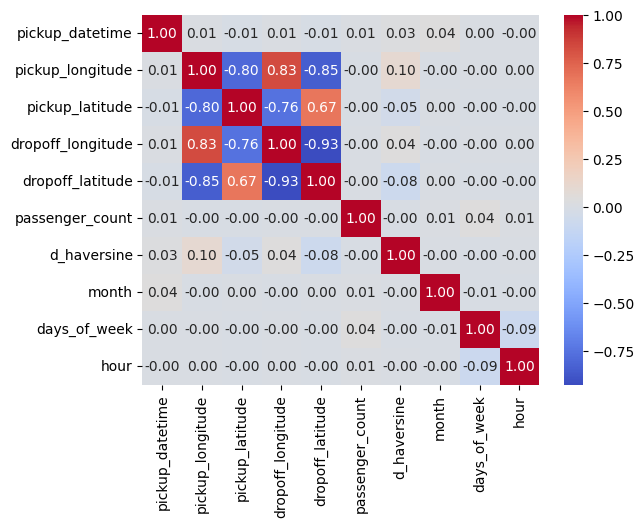

In [ ]:
columns_exclude=['key','date','part_of_day','is_holiday', 'uber_trip']

sns.heatmap(X_train.drop(columns=columns_exclude).corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.show()

### 5 - Tratamiento de valores atipicos y datos faltantes

In [319]:
print("Análisis de datos faltantes:")

missing_data = pd.DataFrame({
    'Valores faltantes' : X_train.isnull().sum(),
    'Porcentaje' : (X_train.isnull().sum() / len(df)) * 100})
print(missing_data)

Análisis de datos faltantes:
                   Valores faltantes  Porcentaje
key                                0      0.0000
date                               0      0.0000
pickup_datetime                    0      0.0000
pickup_longitude                   0      0.0000
pickup_latitude                    0      0.0000
dropoff_longitude                  1      0.0005
dropoff_latitude                   1      0.0005
passenger_count                    0      0.0000
d_haversine                        1      0.0005
month                              0      0.0000
days_of_week                       0      0.0000
hour                               0      0.0000
part_of_day                        0      0.0000
is_holiday                         0      0.0000
uber_trip                          0      0.0000


In [320]:
# Podemos observar un valor faltante en la distancia 
# Imputamos por la mediana

d_haversine_median = df['d_haversine'].median()

df['d_haversine'] = df['d_haversine'].fillna(d_haversine_median) # Reemplazamos los NaN por la mediana

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                200000 non-null  int64              
 1   date               200000 non-null  object             
 2   fare_amount        200000 non-null  float64            
 3   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 4   pickup_longitude   200000 non-null  float64            
 5   pickup_latitude    200000 non-null  float64            
 6   dropoff_longitude  199999 non-null  float64            
 7   dropoff_latitude   199999 non-null  float64            
 8   passenger_count    200000 non-null  float64            
 9   d_haversine        200000 non-null  float64            
 10  month              200000 non-null  int32              
 11  days_of_week       200000 non-null  int32              
 12  hour               200000 non-

Tratamiento de outliers

In [326]:
X_train_sub = X_train.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','key','date','pickup_datetime','passenger_count'])
X_train_sub.columns

Index(['d_haversine', 'month', 'days_of_week', 'hour', 'part_of_day',
       'is_holiday', 'uber_trip'],
      dtype='object')

<Axes: ylabel='d_haversine'>

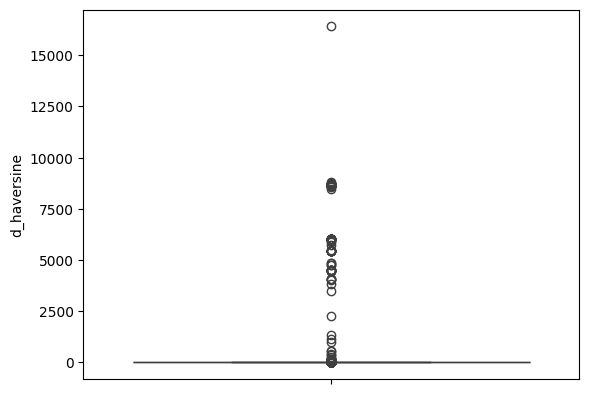

In [325]:
sns.boxplot(X_train_sub['d_haversine'])

In [ ]:
# Tratamiento de valores atipicos en la distancia (USAR SIMPLE IMPUTER)

q99_haversine = X_train_sub['d_haversine'].quantile(0.99)

X_train_sub = X_train_sub[X_train_sub['d_haversine'] < q99_haversine]


median_haversine = X_train_sub['d_haversine'].median()


# Reemplazar valores atípicos por la mediana
X_train_sub.loc[X_train_sub['d_haversine'] > q99_haversine, 'd_haversine'] = median_haversine


<Axes: ylabel='d_haversine'>

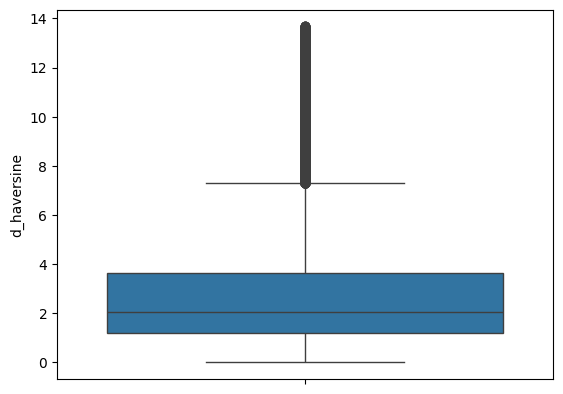

In [331]:
sns.boxplot(X_train_sub['d_haversine'])


<Axes: xlabel='d_haversine', ylabel='fare_amount'>

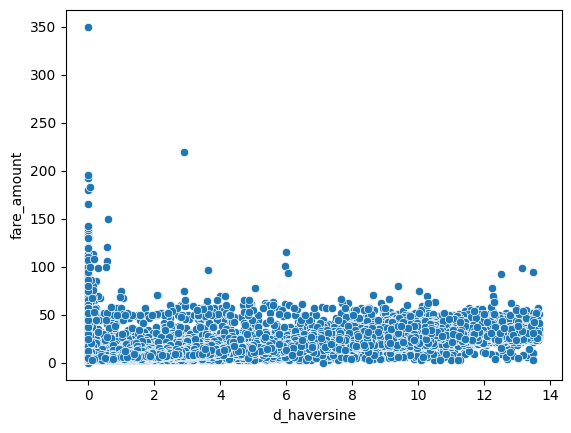

In [332]:
sns.scatterplot(x = X_train_sub['d_haversine'], y = y_train)